In [3]:
import cv2
import numpy as np
from skimage import io, exposure, img_as_ubyte, img_as_float
from skimage.filters import threshold_otsu
from scipy.ndimage import label, median_filter
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.measure import EllipseModel
from astropy.io import fits

# Pre-processing functions

In [4]:
def apply_percentile_threshold(image_data, percentile=99.7):
    threshold_value = np.percentile(image_data, percentile)
    
    return np.clip(image_data, None, threshold_value)

In [5]:
def apply_adaptive_filtering(image_data, size=3):
    return median_filter(image_data, size=size)

In [6]:
def preprocess_image(raw_image, percentile=99.7, size=3):
    preprocessed_image = apply_percentile_threshold(raw_image, percentile)
    preprocessed_image = apply_adaptive_filtering(preprocessed_image, size)

    
    return preprocessed_image

# Detection functions

In [7]:
def normalize_image(image):
    """Normalise l'image pour faciliter le traitement."""
    return cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)


def detect_edges_in_profile(profile, threshold):
    """Détecte les bords gauche et droit d'un profil horizontal ou vertical."""
    left_edge = np.argmax(profile > threshold)
    right_edge = len(profile) - np.argmax(profile[::-1] > threshold) - 1
    return left_edge, right_edge


def find_contour_points(image, center_y, center_x, threshold):
    """Trouve tous les points de contour dans les directions Y et X."""
    contour_points = []
    
    # Trouver les points de contour dans la direction Y (haut et bas)
    for y in range(center_y, image.shape[0]):
        profile = image[y, :]
        left_edge, right_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((y, left_edge))
        contour_points.append((y, right_edge))
    
    for y in range(center_y, -1, -1):
        profile = image[y, :]
        left_edge, right_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((y, left_edge))
        contour_points.append((y, right_edge))
    
    # Trouver les points de contour dans la direction X (gauche et droite)
    for x in range(center_x, image.shape[1]):
        profile = image[:, x]
        top_edge, bottom_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((top_edge, x))
        contour_points.append((bottom_edge, x))
    
    for x in range(center_x, -1, -1):
        profile = image[:, x]
        top_edge, bottom_edge = detect_edges_in_profile(profile, threshold)
        contour_points.append((top_edge, x))
        contour_points.append((bottom_edge, x))
    
    return np.array(contour_points)


def group_contour_points(contour_points, max_distance=10):
    """Regroupe les points de contour en fonction de leur proximité."""
    groups = []
    visited = np.zeros(len(contour_points), dtype=bool)
    
    def euclidean_distance(p1, p2):
        """Calcule la distance euclidienne entre deux points."""
        return np.sqrt(np.sum((np.array(p1) - np.array(p2))**2))

    for i, point in enumerate(contour_points):
        if visited[i]:
            continue
        # Créer un nouveau groupe
        group = [point]
        visited[i] = True
        
        # Chercher les voisins de ce point pour les ajouter au groupe
        stack = [point]
        while stack:
            p = stack.pop()
            for j, q in enumerate(contour_points):
                if not visited[j] and euclidean_distance(p, q) < max_distance:
                    group.append(q)
                    visited[j] = True
                    stack.append(q)
        
        # Ajouter le groupe trouvé
        groups.append(np.array(group))
    
    return groups


def select_group_near_center(groups, center_y, center_x):
    """Sélectionne le groupe le plus proche du centre de l'image."""
    min_distance = float('inf')
    selected_group = None
    
    for group in groups:
        distances = np.linalg.norm(group - np.array([center_y, center_x]), axis=1)
        avg_distance = np.mean(distances)
        
        if avg_distance < min_distance:
            min_distance = avg_distance
            selected_group = group
    
    return selected_group


def fit_ellipse_to_contour(contour_points):
    """Ajuste une ellipse aux points de contour."""
    if len(contour_points) >= 5:
        # Convertir les points en un format approprié pour EllipseModel
        group_y, group_x = zip(*contour_points)
        
        # Ajuster l'ellipse aux points du groupe
        ellipse = EllipseModel()
        ellipse.estimate(np.column_stack((group_x, group_y)))

        # Obtenir les paramètres de l'ellipse ajustée
        yc, xc, a, b, theta = ellipse.params

        # Retourner les paramètres sous la forme demandée
        return (yc, xc), (a, b), theta
    else:
        print("Pas assez de points pour ajuster une ellipse.")
        return None


def plot_contour_and_ellipse(image, contour_points, ellipse):
    """Affiche l'image avec le contour détecté et l'ellipse ajustée."""
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.plot(contour_points[:, 1], contour_points[:, 0], 'r.', markersize=1)
    
    # Extraire les paramètres de l'ellipse ajustée
    ellipse_center = ellipse[0]
    ellipse_axes = ellipse[1]
    ellipse_angle = ellipse[2]
    
    # Générer les points de l'ellipse ajustée
    t = np.linspace(0, 2 * np.pi, 100)
    xc, yc = ellipse_center
    a, b = ellipse_axes
    theta = ellipse_angle
    
    ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    

    # Afficher l'ellipse ajustée
    plt.plot(ellipse_x, ellipse_y, color='blue', linewidth=2, label='Ellipse ajustée')
    
    plt.title("Contour extérieur et ellipse ajustée de la galaxie")
    plt.legend()
    plt.show()



def detect_contour_with_ellipse(image, max_distance=10, threshold=0.1):
    """Fonction principale pour détecter les contours et ajuster une ellipse."""
    norm_image = normalize_image(image)
    
    # Calculer les coordonnées centrales
    center_y, center_x = np.array(norm_image.shape) // 2
    
    # Trouver les points de contour dans les directions Y et X
    contour_points = find_contour_points(norm_image, center_y, center_x, threshold)
    # Sauvegarder les points de contour dans un fichier texte
    np.savetxt('contour_points.txt', contour_points, fmt='%d', delimiter=',')
    
    # Regrouper les points voisins
    groups = group_contour_points(contour_points, max_distance)
    
    # Sélectionner le groupe proche du centre
    selected_group = select_group_near_center(groups, center_y, center_x)
    
    if selected_group is not None:
        # Ajuster l'ellipse
        ellipse = fit_ellipse_to_contour(selected_group)
        if ellipse:
            plot_contour_and_ellipse(norm_image, selected_group, ellipse)
    else:
        print("Aucun groupe trouvé près du centre.")

### First Appraoch:
- Import all three images in red,green and infrared

In [86]:

image_path = './../test/img-r/PGC0000282_r.fits'
hdu_list = fits.open(image_path)
raw_image_r = hdu_list[0].data

image_path = './../test/img-g/PGC0000282_g.fits'
hdu_list = fits.open(image_path)
raw_image_g = hdu_list[0].data

image_path = './../test/img-i/PGC0000282_i.fits'
hdu_list = fits.open(image_path)
raw_image_i = hdu_list[0].data

Preprocess the image by using the threshold technique 

In [87]:
preprocessed_image_g = preprocess_image(raw_image_g)
preprocessed_image_r = preprocess_image(raw_image_r)
preprocessed_image_i = preprocess_image(raw_image_i)

Plot the 3 images as long as an superposed of the images together

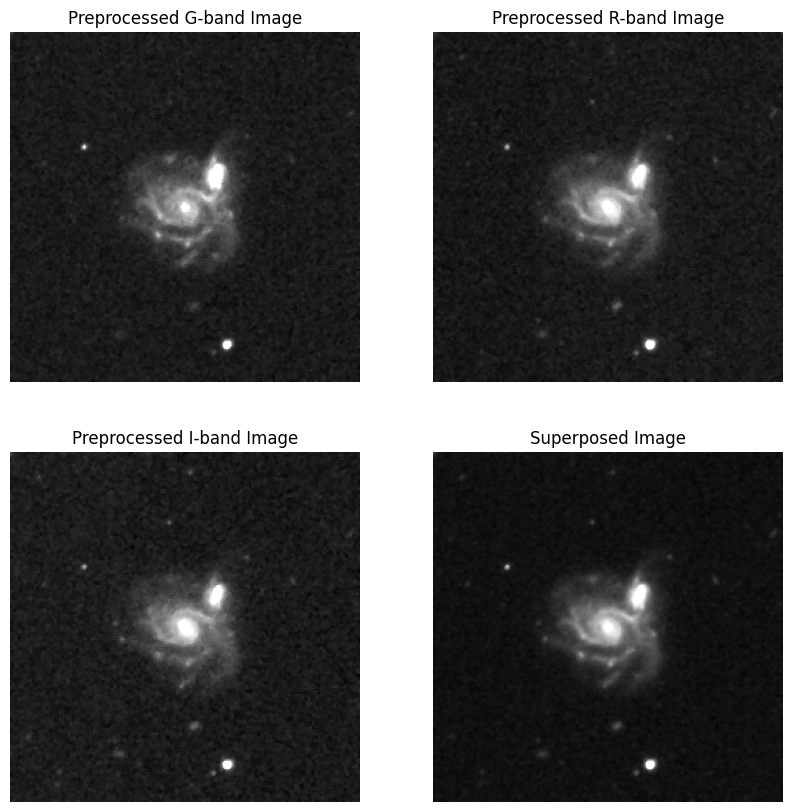

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                         
# Plot the preprocessed g-band image
axes[0][0].imshow(preprocessed_image_g, cmap='gray')
axes[0][0].set_title('Preprocessed G-band Image')
axes[0][0].axis('off')

# Plot the preprocessed r-band image
axes[0][1].imshow(preprocessed_image_r, cmap='gray')
axes[0][1].set_title('Preprocessed R-band Image')
axes[0][1].axis('off')

# Plot the preprocessed i-band image
axes[1][0].imshow(preprocessed_image_i, cmap='gray')
axes[1][0].set_title('Preprocessed I-band Image')
axes[1][0].axis('off')


# Superpose the preprocessed images
superposed_image = (preprocessed_image_g + preprocessed_image_r + preprocessed_image_i) / 3
axes[1][1].imshow(superposed_image, cmap='gray')
axes[1][1].set_title('Superposed Image')
axes[1][1].axis('off')

plt.show()


We take the superposed image and apply a Laplacian filter to enhace it

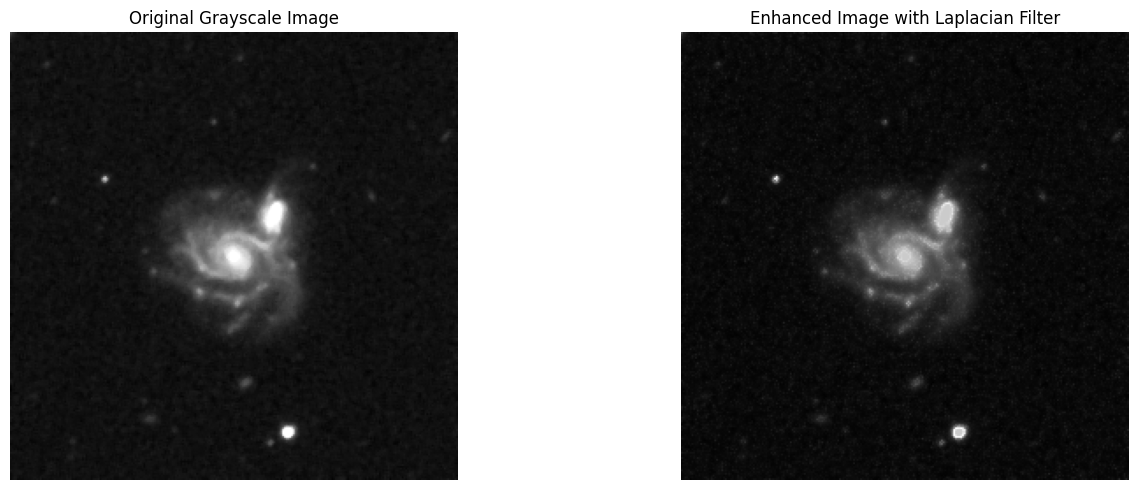

In [113]:
# Apply Laplacian filter
gray_image= cv2.normalize(superposed_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

# Enhance edges by adding Laplacian result to original
enhanced_image = cv2.addWeighted(gray_image, 0.8, laplacian, 0.5, 0)

# Plot the original grayscale image
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(superposed_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Image with Laplacian Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

### BIG TEST IMAGE RECOGNITION

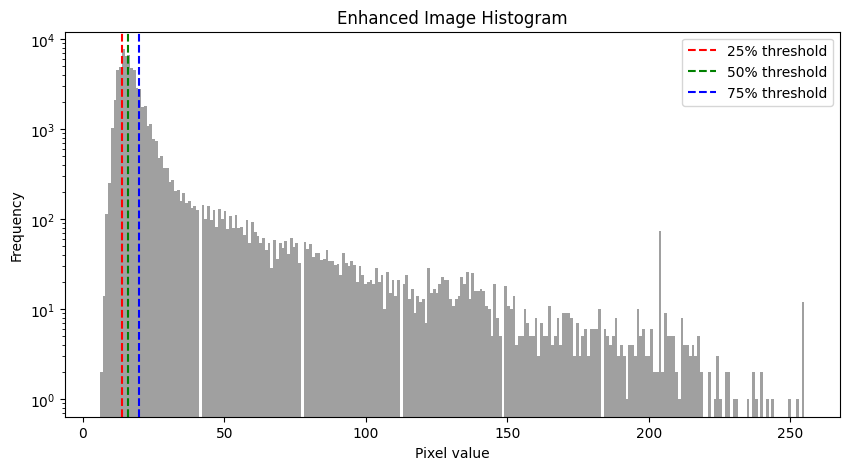

In [114]:
fig, ax_hist = plt.subplots(figsize=(10, 5))

# Flatten the enhanced image to get pixel values
pixel_values = enhanced_image.ravel()

# Plot the histogram
ax_hist.hist(pixel_values, bins=256, color='gray', alpha=0.75)
ax_hist.set_title("Enhanced Image Histogram")
ax_hist.set_xlabel('Pixel value')
ax_hist.set_ylabel('Frequency')
ax_hist.set_yscale('log')

# Vertical lines for the percentiles
percentiles = [25, 50, 75]
colors = ['red', 'green', 'blue']
for pct, color in zip(percentiles, colors):
    value = np.percentile(pixel_values, pct)
    ax_hist.axvline(value, color=color, linestyle='--', label=f'{pct}% threshold')
    ax_hist.legend(loc='upper right')

plt.show()
    

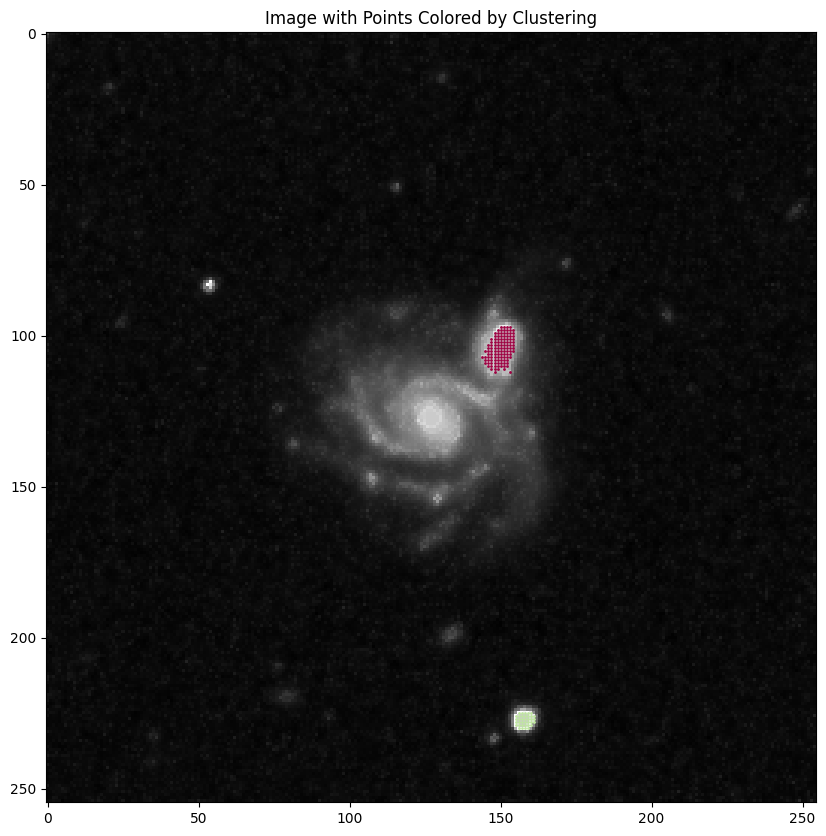

In [115]:
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse

threshold = 150  # Set your desired threshold value

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
ax.imshow(enhanced_image, cmap='gray')

# Find the coordinates of pixels with intensity above the threshold (75% of the max intensity)
y_coords, x_coords = np.where(enhanced_image > np.max(enhanced_image) * 0.75)

# Combine x and y coordinates into a single array
coords = np.column_stack((x_coords, y_coords))

# Use DBSCAN to group points based on their closeness
db = DBSCAN(eps=3, min_samples=5).fit(coords)
labels = db.labels_

# Plot the points with different colors based on clustering
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

def select_central_labels(image, coords, labels):
    center_y, center_x = np.array(image.shape) // 2
    central_label = None
    min_distance = float('inf')
    
    for point, label in zip(coords, labels):
        if label != -1:  # Ignore noise points
            distance_to_center = np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2)
            if distance_to_center < min_distance:
                min_distance = distance_to_center
                central_label = label
                
    return central_label

central_label = select_central_labels(enhanced_image, coords, labels)

for k, col in zip(unique_labels, colors):
    if k == -1 or k == central_label:
        # Black used for noise and skip central label points
        continue

    class_member_mask = (labels == k)

    xy = coords[class_member_mask]
    ax.scatter(xy[:, 0], xy[:, 1], color=col, s=1)

# Set the title and show the plot
ax.set_title('Image with Points Colored by Clustering')
plt.show()


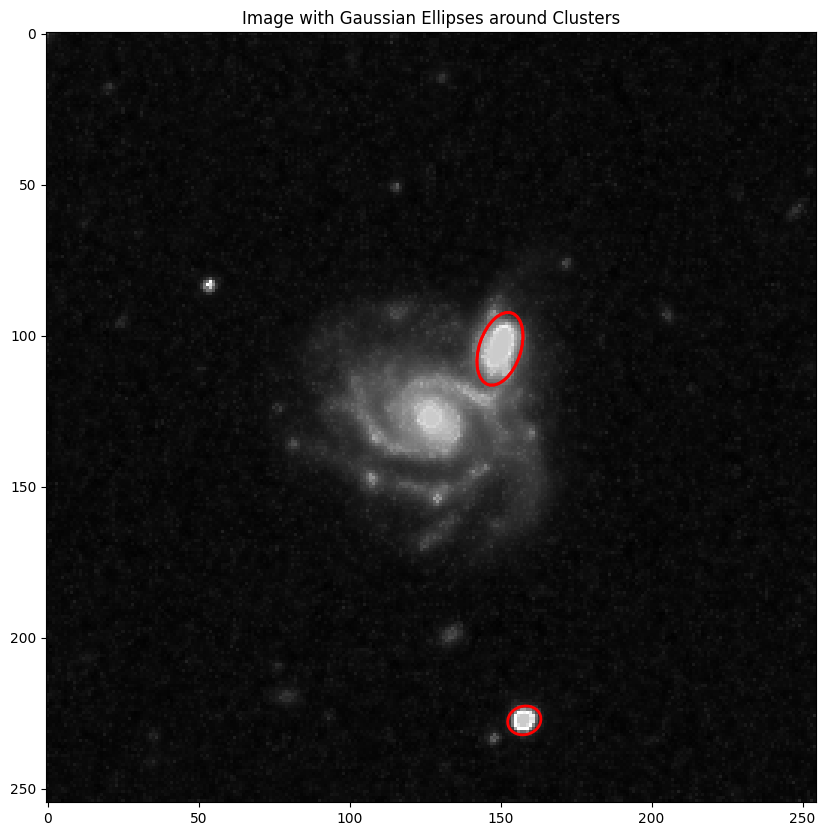

In [116]:


def fit_gaussian_ellipse(points):
    if len(points) < 5:
        return None

    # Calculate the mean and covariance matrix of the points
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)

    # Eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Calculate the width and height of the ellipse and increase by 10%
    width, height = 2 * np.sqrt(eigenvalues) * 3

    return mean, width, height, angle

# Plot Gaussian ellipses for each cluster other than the central one
plt.figure(figsize=(10, 10))
ellipses=[]
for k in unique_labels:
    if k == -1 or k == central_label:
        continue

    class_member_mask = (labels == k)
    cluster_points = coords[class_member_mask]

    ellipse_params = fit_gaussian_ellipse(cluster_points)
    if ellipse_params:
        mean, width, height, angle = ellipse_params
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='red', fc='None', lw=2)
        ellipses.append(ellipse)

        # Plot the image
        plt.imshow(enhanced_image, cmap='gray')

        # Add ellipses to the plot
        for ellipse in ellipses:
            plt.gca().add_patch(ellipse)
# Set the title and show the plot with ellipses
plt.title('Image with Gaussian Ellipses around Clusters')
plt.show()


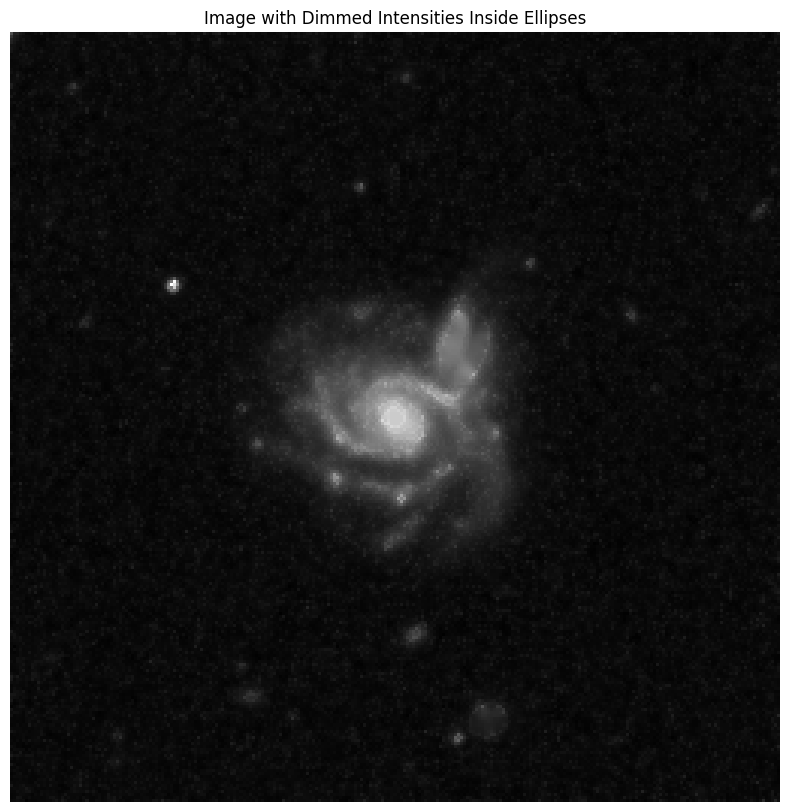

In [117]:
from scipy.ndimage import gaussian_filter

# Create a mask for the points inside the ellipses
mask = np.zeros_like(enhanced_image, dtype=bool)

for ellipse in ellipses:
    center = ellipse.center
    width = ellipse.width
    height = ellipse.height
    angle = np.deg2rad(ellipse.angle)
    
    y, x = np.ogrid[:enhanced_image.shape[0], :enhanced_image.shape[1]]
    x_centered = x - center[0]
    y_centered = y - center[1]
    
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    
    ellipse_mask = ((x_centered * cos_angle + y_centered * sin_angle) ** 2 / (width / 2) ** 2 +
                    (x_centered * sin_angle - y_centered * cos_angle) ** 2 / (height / 2) ** 2 <= 1)
    
    mask |= ellipse_mask

# Apply Gaussian filter to the masked region
# Create a copy of the enhanced image to apply inpainting
dimmed_image = enhanced_image.copy()

# Apply inpainting to the masked region
inpainted_image = cv2.inpaint(dimmed_image, mask.astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Update the dimmed image with the inpainted result
dimmed_image[mask] = inpainted_image[mask]

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(dimmed_image, cmap='gray')
plt.title('Image with Dimmed Intensities Inside Ellipses')
plt.axis('off')
plt.show()